In [1]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
## Plotly
import re
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import nltk
import json
from sklearn.feature_extraction.text import CountVectorizer
import time
from nltk.stem.wordnet import WordNetLemmatizer
from contextlib import contextmanager
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
# Create a function to calculate the error metrics, since we'll be doing this several times
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    Accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),2)
    Precision = round((true_pos) / (true_pos + false_pos),2)
    Recall = round((true_pos) / (true_pos + false_neg),2)
    F1 = round(2 * (Precision * Recall) / (Precision + Recall),2)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predicted)
    AUC = round(auc(false_positive_rate, true_positive_rate),2)
    
    cm_results = [Accuracy, Precision, Recall, F1, AUC]
    return cm_results

In [3]:
@contextmanager
def timer(msg):
    t0 = time.time()
    print(f'[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'[{msg}] done in {elapsed_time / 60:.2f} min.')

In [4]:
data = pd.read_csv('cleaned_short_simple.csv')

In [5]:
data = data.dropna()

In [6]:
data.head()

,y,comment_text
0,0,great story man wonder person yelled shut fuck...
1,1,yet call muslims acts get pilloried okay smear...
2,0,people drive cars ones cause wear tear roads p...
3,0,mormons complicated relationship federal law
4,0,thing


In [7]:
x = data['comment_text']
y = data['y']

In [8]:
probabilities = {}

## Glove 100

In [10]:
embeddings_index = dict()
f = open('/Users/kelvin/pretrained_models/glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [11]:
vocabulary_size = 30000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
data = pad_sequences(sequences, maxlen=50)

In [13]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42, stratify=y)

# Balance train set
x_balance, y_balance = RandomOverSampler().fit_sample(pd.DataFrame(x_train), y_train)

In [14]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [15]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.039741  ,  0.035052  ,  0.32988   , ..., -0.26137   ,
         0.55432999,  0.24510001],
       [ 0.29019001,  0.80497003,  0.31187001, ..., -0.33603001,
         0.45998001, -0.11278   ],
       ...,
       [ 0.026652  , -0.30943   , -0.11584   , ...,  0.17144001,
        -0.080895  , -0.084585  ],
       [-0.31753001, -0.34656   , -0.25007999, ...,  0.0012173 ,
         0.37143001,  0.086637  ],
       [-0.2843    ,  0.0089734 ,  0.99184   , ..., -0.067181  ,
         0.76041001, -0.33963001]])

In [268]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.3))
model_glove.add(Conv1D(64, 5, activation='relu', padding='same'))
model_glove.add(MaxPooling1D(pool_size=4, padding='same'))
model_glove.add(Dropout(0.3))
model_glove.add(Conv1D(64, 5, activation='relu', padding='same'))
model_glove.add(MaxPooling1D(pool_size=4, padding='same'))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [269]:
model_glove.fit(x_balance, y_balance, epochs = 3)

Epoch 1/3
314372/314372 [==============================] - 59s 187us/step - loss: 0.4514 - accuracy: 0.7883
Epoch 2/3
314372/314372 [==============================] - 58s 183us/step - loss: 0.4192 - accuracy: 0.8087
Epoch 3/3
314372/314372 [==============================] - 58s 184us/step - loss: 0.4092 - accuracy: 0.8134


In [271]:
y_pred_100_prob = model_glove.predict(x_test)

In [272]:
y_pred_100 = np.where(y_pred_100_prob >= 0.5, 1, 0)

In [273]:
probabilities['Glove100'] = y_pred_100_prob

## GLOVE 300

In [274]:
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [275]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [276]:
model_glove1 = Sequential()
model_glove1.add(Embedding(vocabulary_size, 300, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove1.add(Dropout(0.3))
model_glove1.add(Conv1D(64, 5, activation='relu', padding='same'))
model_glove1.add(MaxPooling1D(pool_size=4, padding='same'))
model_glove1.add(Dropout(0.3))
model_glove1.add(Conv1D(64, 5, activation='relu', padding='same'))
model_glove1.add(MaxPooling1D(pool_size=4, padding='same'))
model_glove1.add(LSTM(100))
model_glove1.add(Dense(1, activation='sigmoid'))
model_glove1.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [277]:
model_glove1.fit(x_balance, y_balance, epochs = 3)

Epoch 1/3
314372/314372 [==============================] - 69s 218us/step - loss: 0.4036 - accuracy: 0.8170
Epoch 2/3
314372/314372 [==============================] - 68s 216us/step - loss: 0.3590 - accuracy: 0.8417
Epoch 3/3
314372/314372 [==============================] - 68s 216us/step - loss: 0.3434 - accuracy: 0.8505


In [279]:
y_pred_300_prob = model_glove1.predict(x_test)

In [280]:
y_pred_300 = np.where(y_pred_300_prob >= 0.5, 1, 0)

In [281]:
probabilities['Glove300'] = y_pred_300_prob

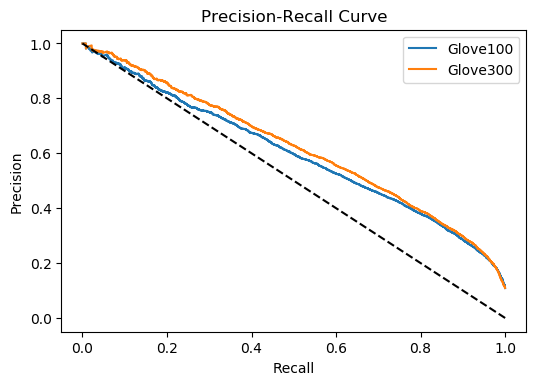

In [283]:
plt.figure(dpi=100)
for model, prob in probabilities.items():
    if model in ['Glove100', 'Glove300']:
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob)
    else:
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob[:, 1])
    plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
    plt.legend(probabilities.keys())
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
plt.plot([1, 0], [0, 1], c='black', ls='--')

In [304]:
y_pred_100 = np.where(y_pred_100_prob >= 0.58, 1, 0)
y_pred_300 = np.where(y_pred_300_prob >= 0.57, 1, 0)

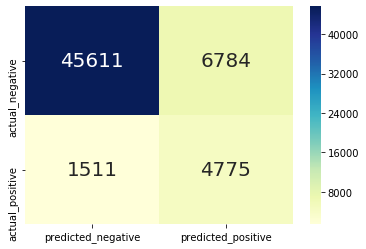

In [305]:
cm1 = conf_matrix(y_test, y_pred_100);

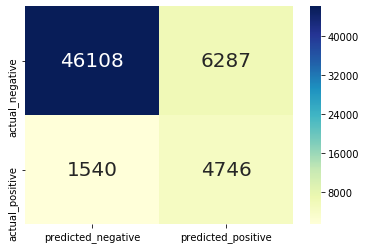

In [306]:
cm2 = conf_matrix(y_test, y_pred_300);

In [308]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm1, cm2)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']])
results_nb.columns = ['CNN_LSTM_100', 'CNN_LSTM_300']
results_nb

,CNN_LSTM_100,CNN_LSTM_300
Accuracy,0.86,0.87
Precision,0.41,0.43
Recall,0.76,0.76
F1 Score,0.53,0.55
AUC,0.82,0.82


In [309]:
glove100 = pd.DataFrame(probabilities['Glove100'], columns=['Glove100'])

In [310]:
glove300 = pd.DataFrame(probabilities['Glove300'], columns=['Glove300'])

In [311]:
probs = pd.concat([glove100, glove300], axis=1)

In [312]:
probs.to_csv('probs_cnn.csv', index=False)